In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from simpledbf import Dbf5

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVR

import operator 
from ReclassifyLandUse import ReC

import importlib
import DamageEstimation
importlib.reload( DamageEstimation )
from DamageEstimation import DepthDamage

import pickle
from pyogrio import read_dataframe, write_dataframe
from geo_northarrow import add_north_arrow
from  NFIP_calculator import Insurer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.pylab import cm
from matplotlib.colors import rgb2hex


import warnings
import seaborn as sns
import scipy.stats as stats

warnings.filterwarnings('ignore')

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [4]:
sys.path

['/Users/yuhan/Desktop/Gradient_Boost_code/examples',
 '/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python311.zip',
 '/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11',
 '/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/lib-dynload',
 '',
 '/Users/yuhan/.local/lib/python3.11/site-packages',
 '/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages']

In [2]:
fp = r'../inputs/gis_data/Parcel_input_sce1.shp'
Geodata = read_dataframe(fp)


In [3]:
print(Geodata.columns)
print(Geodata.crs)

Index(['index', 'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE',
       'landCode', 'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode',
       'waterclass', 'watername', 'parkigcode', 'parkigclas', 'LUCode01re',
       'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode',
       'policyCost', 'policyCoun', 'elevationN', 'Content_Bu', 'ACRES',
       'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'NumStories', 'Foundation',
       'FirstFloor', 'ContentCos', 'BldgDamage', 'CDDF_ID', 'YEARBUILT',
       'Tract', 'Insurance', 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
       'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority',
       'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist',
       'CoastDist', 'WetlatDist', 'floodzones', 'buildDEM', 'H_ft', 'PArea',
       'slope_mhw', 'logAccess', 'area_2', 'pararea', 'Risk', 'NN1', 'NN2',
       'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2', 'WaterCoast',
       'predprobs', 'predLU',

In [4]:
Geodata = Geodata.to_crs({'init':'epsg:4326'})


In [23]:
color_mapping = { 0: "aqua", 1: "gold", 2: "firebrick",
                  3: "pink", 4: "mediumorchid", 5: "orange", 
                  6: "darkgreen", 7 : "limegreen"}


label_mapping = { 0: "buyout land", 1: "residential land",
                  2: "commercial land", 3: "industrial land", 
                  4: "infrastructural land", 5: "public land",
                  6: "green land", 7 : "open space"}

Geodata["Colors"] = Geodata["LUC"].map(color_mapping)
Geodata["LUName"] = Geodata["LUC"].map(label_mapping)



/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_4011/2539535468.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()


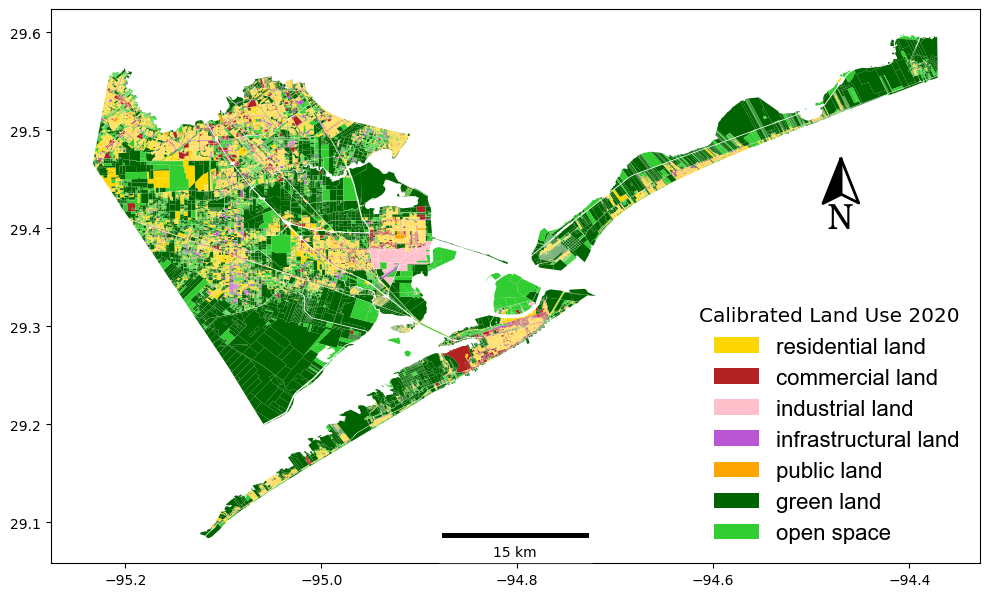

In [43]:
fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in new_df.groupby('LUC'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Arial', 'size' : 16},
            handles=[ *handles,*pmarks ],
            title="Calibrated Land Use 2020",
            title_fontsize='x-large', 
            loc='lower right',
            fontsize= 14,
            frameon=False )
leg._legend_box.align = "right"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()

#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)

plt.tight_layout()

#plt.savefig('LandUse_cali.png',dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


['0 - 100', '200 - 300', '0 - 0', 'Above 300', '100 - 200']
Categories (5, object): ['0 - 0' < '0 - 100' < '100 - 200' < '200 - 300' < 'Above 300']
0 - 0
0 - 100
100 - 200
200 - 300
Above 300


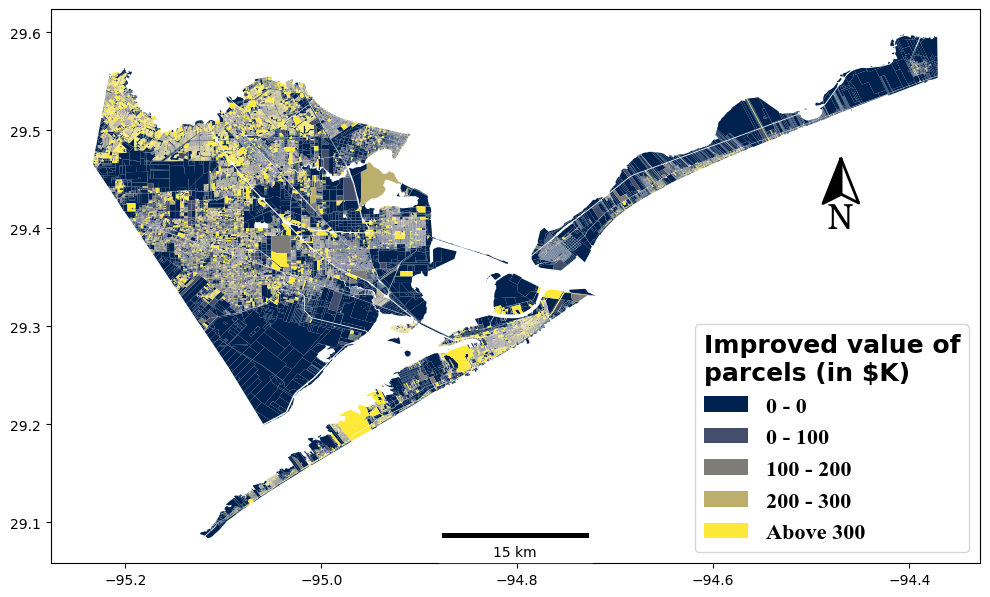

In [64]:
cmap = cm.get_cmap('cividis', 5)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['VAL19IMP'] = Geodata['VAL19IMP'].astype(float)
bins = [Geodata['VAL19IMP'].min()-1, 0, 1.0e5, 2e5, 3e5, Geodata['VAL19IMP'].max() + 1]  # Adjust these values based on your data range
Geodata['ImpValCat'] = pd.cut( Geodata['VAL19IMP'], bins, 
                               labels=['0 - 0', '0 - 100',  '100 - 200',  '200 - 300', 
                                       'Above 300'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 0'  : rgb2hex(cmap(0)),   '0 - 100': rgb2hex(cmap(1)), 
              '100 - 200': rgb2hex(cmap(2)), '200 - 300': rgb2hex(cmap(3)),
              'Above 300': rgb2hex(cmap(4))  }
Geodata['ImpValColor'] = Geodata['ImpValCat'].map(color_map)

print( Geodata['ImpValCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['ImpValCat'] == category ].plot( column='ImpValCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.0, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Improved value of\nparcels (in $K)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/imporved_value.pdf', bbox_inches='tight', pad_inches=0)

plt.show()


In [20]:
Geodata['DEMm'] = Geodata['DEM'] * 0.3048
Geodata['DEMm'].quantile( [0.25, 0.5, 0.75, 1 ])

0.25     2.117684
0.50     3.788115
0.75     5.814631
1.00    23.582132
Name: DEMm, dtype: float64

['2 - 3', '6 - 10', '0 - 2', '3 - 6', 'Above 10']
Categories (5, object): ['0 - 2' < '2 - 3' < '3 - 6' < '6 - 10' < 'Above 10']
0 - 2
2 - 3
3 - 6
6 - 10
Above 10


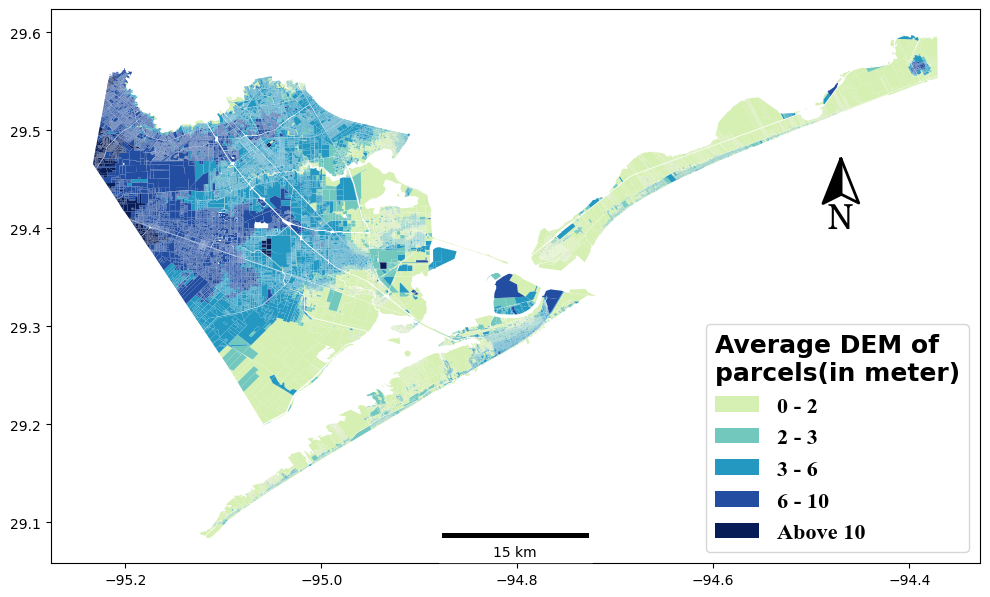

In [23]:

cmap = cm.get_cmap('YlGnBu', 6)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['DEMm'] = Geodata['DEMm'].astype(float)
bins = [Geodata['DEMm'].min()-1, 2, 3, 6, 10, Geodata['DEMm'].max() + 1]  # Adjust these values based on your data range
Geodata['DEMmCat'] = pd.cut( Geodata['DEMm'], bins, 
                               labels=['0 - 2', '2 - 3',  '3 - 6',  '6 - 10', 
                                       'Above 10'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 2'  : rgb2hex(cmap(1)),   '2 - 3': rgb2hex(cmap(2)), 
              '3 - 6': rgb2hex(cmap(3)), '6 - 10': rgb2hex(cmap(4)),
              'Above 10': rgb2hex(cmap(5))  }

print( Geodata['DEMmCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['DEMmCat'] == category ].plot( column='DEMmCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.0, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Average DEM of\nparcels(in meter)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/dem——meter.pdf', bbox_inches='tight', pad_inches=0)

plt.show()




In [18]:
Geodata['Risk'].quantile( [0.25, 0.5, 0.75, 1 ])

0.25    0.062100
0.50    0.274500
0.75    0.522712
1.00    1.984500
Name: Risk, dtype: float64

['0.25 - 0.50', '0.00 - 0.05', '0.50 - 1.00', '0.05 - 0.25', 'Above 1.00']
Categories (5, object): ['0.00 - 0.05' < '0.05 - 0.25' < '0.25 - 0.50' < '0.50 - 1.00' < 'Above 1.00']
0.00 - 0.05
0.05 - 0.25
0.25 - 0.50
0.50 - 1.00
Above 1.00


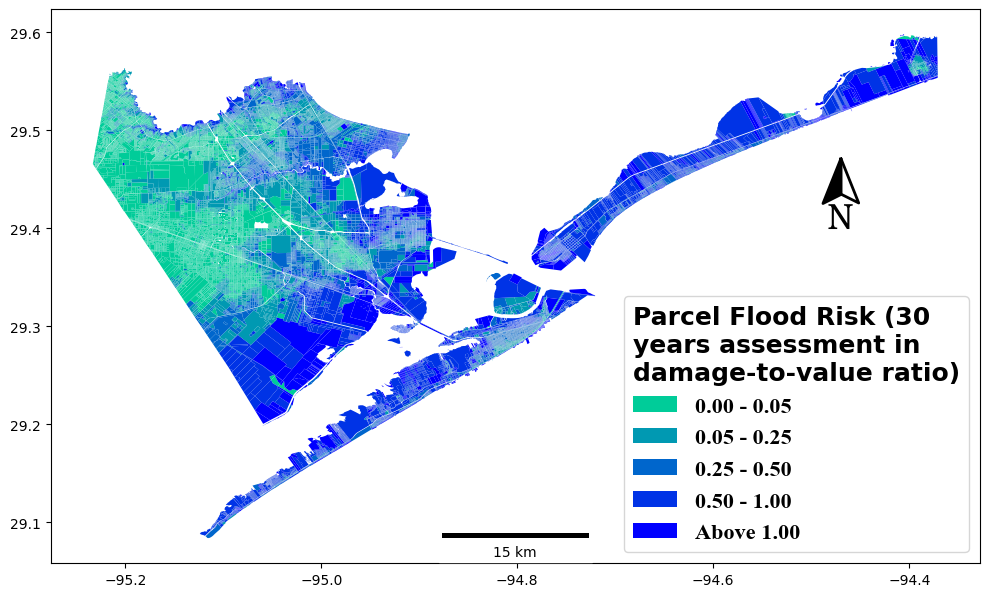

In [16]:

cmap = cm.get_cmap('winter_r', 6)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['Risk'] = Geodata['Risk'].astype(float)
bins = [Geodata['Risk'].min()-1, 0.05, 0.25, 0.5, 1, Geodata['Risk'].max() + 1]  # Adjust these values based on your data range
Geodata['RiskCat'] = pd.cut( Geodata['Risk'], bins, 
                               labels=['0.00 - 0.05', '0.05 - 0.25',  '0.25 - 0.50',  '0.50 - 1.00', 
                                       'Above 1.00'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0.00 - 0.05'  : rgb2hex(cmap(1)),   '0.05 - 0.25': rgb2hex(cmap(2)), 
              '0.25 - 0.50': rgb2hex(cmap(3)), '0.50 - 1.00': rgb2hex(cmap(4)),
              'Above 1.00': rgb2hex(cmap(5))  }

print( Geodata['RiskCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['RiskCat'] == category ].plot( column='RiskCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.0, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Parcel Flood Risk (30\nyears assessment in\ndamage-to-value ratio)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)
#plt.savefig('../output_images/FloodRisk.pdf', bbox_inches='tight', pad_inches=0)

plt.show()




In [17]:
Geodata['FirstFloorm'] = Geodata['FirstFloor'] * 0.3048

Geodata['FirstFloorm'].quantile( [0.25, 0.5, 0.75, 1 ])

0.25    0.929667
0.50    1.199012
0.75    1.421029
1.00    2.861337
Name: FirstFloorm, dtype: float64

['1.2 - 1.5', '0 - 1', '1.5 - 2.5', '1 - 1.2', 'Above 2.5']
Categories (5, object): ['0 - 1' < '1 - 1.2' < '1.2 - 1.5' < '1.5 - 2.5' < 'Above 2.5']
0 - 1
1 - 1.2
1.2 - 1.5
1.5 - 2.5
Above 2.5


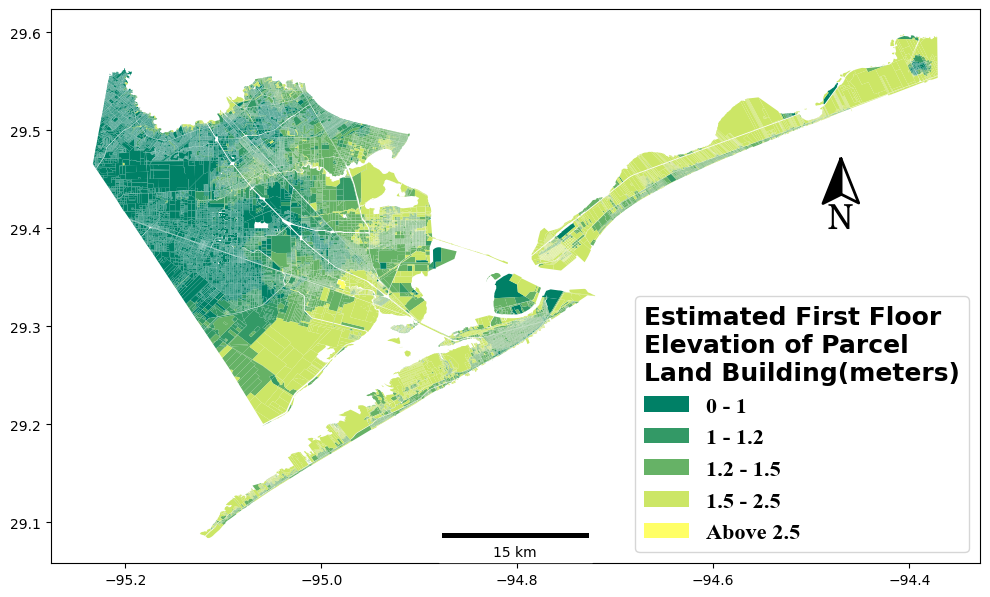

In [28]:
Geodata['FirstFloorm'] = Geodata['FirstFloor'] * 0.3048
cmap = cm.get_cmap('summer', 6)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['FirstFloorm'] = Geodata['FirstFloorm'].astype(float)
bins = [Geodata['FirstFloorm'].min()-1, 1, 1.2, 1.5, 2.5, Geodata['Risk'].max() + 1]  # Adjust these values based on your data range
Geodata['FirstFloorCat'] = pd.cut( Geodata['FirstFloorm'], bins, 
                               labels=['0 - 1', '1 - 1.2',  '1.2 - 1.5',  '1.5 - 2.5', 
                                       'Above 2.5'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 1'  : rgb2hex(cmap(0)),   '1 - 1.2': rgb2hex(cmap(1)), 
              '1.2 - 1.5': rgb2hex(cmap(2)), '1.5 - 2.5': rgb2hex(cmap(4)),
              'Above 2.5': rgb2hex(cmap(5))  }

print( Geodata['FirstFloorCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['FirstFloorCat'] == category ].plot( column='FirstFloorCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.0, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Estimated First Floor\nElevation of Parcel\nLand Building(meters)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/FirstFloor.pdf', bbox_inches='tight', pad_inches=0)

plt.show()


In [104]:
Geodata["WaterCoastDist"] = Geodata.apply(lambda x: x['NEAR_DIST'] if x['NEAR_DIST'] < x['NEA_DIST2'] else x['NEA_DIST2'] , axis=1)
Geodata["WaterCoastDist"] = Geodata.apply(lambda x: x['WaterCoastDist'] if x['floodzones'] in [3, 5, 6, 8, 10] else x['CoastDist'] , axis=1)

Geodata['WaterCoastDist'].quantile( [0.25, 0.5, 0.75, 1 ])
#Geodata.CoastDist
#Geodata.floodzones.isin([3, 5, 6, 8, 10])

0.25      253.656176
0.50     4605.075553
0.75    28317.841481
1.00    73856.640353
Name: WaterCoastDist, dtype: float64

['500 - 1000', '1000 - 6000', 'Above 6000', '0 - 150', '150 - 500']
Categories (5, object): ['0 - 150' < '150 - 500' < '500 - 1000' < '1000 - 6000' < 'Above 6000']
0 - 150
150 - 500
500 - 1000
1000 - 6000
Above 6000


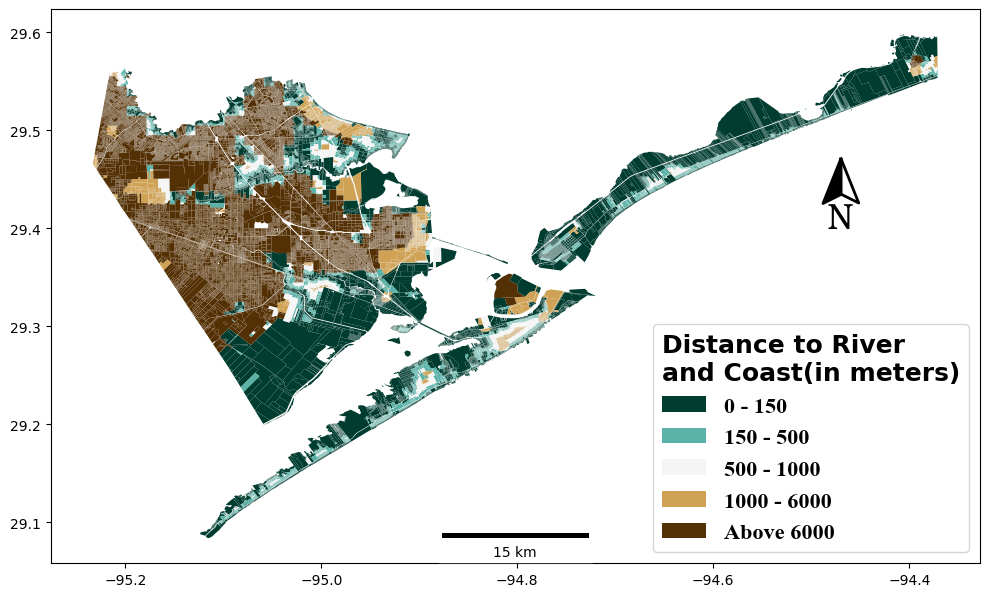

In [105]:

cmap = cm.get_cmap('BrBG_r', 5)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['WaterCoastDist'] = Geodata['WaterCoastDist'].astype(float)
bins = [Geodata['WaterCoastDist'].min()-1, 150, 500, 1000, 6000, Geodata['WaterCoastDist'].max() + 1]  # Adjust these values based on your data range
Geodata['WaterDistCat'] = pd.cut( Geodata['WaterCoastDist'], bins, 
                               labels=['0 - 150', '150 - 500',  '500 - 1000',  '1000 - 6000', 
                                       'Above 6000'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 150'  : rgb2hex(cmap(0)),   '150 - 500': rgb2hex(cmap(1)), 
              '500 - 1000': rgb2hex(cmap(2)), '1000 - 6000': rgb2hex(cmap(3)),
              'Above 6000': rgb2hex(cmap(4))  }

print( Geodata['WaterDistCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['WaterDistCat'] == category ].plot( column='WaterDistCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.0, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Distance to River\nand Coast(in meters)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/WaterDist.pdf', bbox_inches='tight', pad_inches=0)

plt.show()


In [80]:
Geodata["Insurance"] = Geodata.apply(lambda x: x['Insurance'] if x['VAL19IMP'] > 50000 and  x['LUCode'] < 2 else 0 , axis=1)
Geodata['Insurance'].quantile( [0.25, 0.5, 0.75, 1 ])


0.25        0.000
0.50      350.000
0.75     2282.945
1.00    11000.000
Name: Insurance, dtype: float64

['0 - 0', '0 - 500', '500 - 2000', '2000 - 10000', 'Above 10000']
Categories (5, object): ['0 - 0' < '0 - 500' < '500 - 2000' < '2000 - 10000' < 'Above 10000']
0 - 0
0 - 500
500 - 2000
2000 - 10000
Above 10000


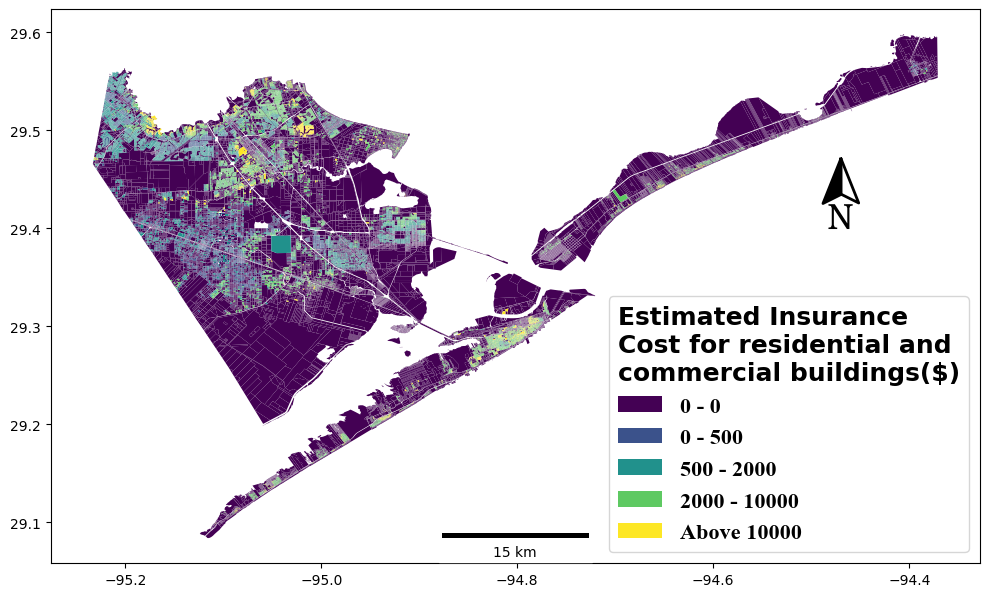

In [92]:
cmap = cm.get_cmap('viridis', 5)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['Insurance'] = Geodata['Insurance'].astype(float)
bins = [Geodata['Insurance'].min()-1, 0, 500, 2000, 10000, Geodata['Insurance'].max() + 1]  # Adjust these values based on your data range
Geodata['InsuranceCat'] = pd.cut( Geodata['Insurance'], bins, 
                               labels=['0 - 0', '0 - 500',  '500 - 2000',  '2000 - 10000', 
                                       'Above 10000'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 0'  : rgb2hex(cmap(0)),   '0 - 500': rgb2hex(cmap(1)), 
              '500 - 2000': rgb2hex(cmap(2)), '2000 - 10000': rgb2hex(cmap(3)),
              'Above 10000': rgb2hex(cmap(4))  }

print( Geodata['InsuranceCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['InsuranceCat'] == category ].plot( column='InsuranceCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.0, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Estimated Insurance\nCost for residential and\n commercial buildings($)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/Insurance.pdf', bbox_inches='tight', pad_inches=0)

plt.show()
